In [1]:
from fastai2.vision.all import *
from torchvision import models

In [2]:
path = untar_data(URLs.MNIST_TINY)
path

Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny')

In [3]:
path.ls()

(#5) [Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/labels.csv'),Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/models'),Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test'),Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/train'),Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/valid')]

MNIST contains 1-channel images, more generally known as "grayscale images". If you're planning to use a pretrained model then you have a problem here, almost all pretrained models are trained on 3-channel images (Images with RGB colour channels) therefore you can't use them with pretrained weights directly, If you want to use a pretrained model you can try converting this 1-channel image to 3-channel images is simple all you have to do is repeat the channel 3 times and you have a 3-channel image, with PIL it's just `img.convert("RGB")`.

# 1-channel approach

In [4]:
blocks = (ImageBlock(cls=PILImageBW), CategoryBlock) #PILImageBW says the image is a 1-channel image

In [5]:
dblock = DataBlock(blocks=blocks,
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(),
                   get_y=parent_label)

In [6]:
dls = dblock.dataloaders(path,num_workers=0)

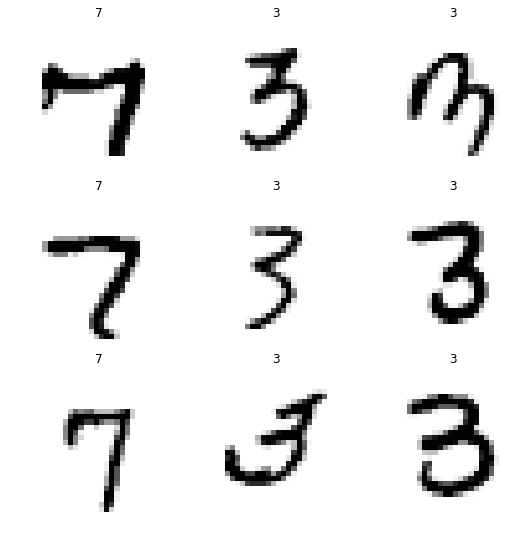

In [7]:
dls.show_batch()

In [8]:
#Let's check the shape of the input images
batch = dls.one_batch()
batch[0].shape #[bs, num_channels, height, width]

torch.Size([64, 1, 28, 28])

In [9]:
class SimpleClassifier(Module):
    def __init__(self):
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(9216,24)
        self.linear2 = nn.Linear(24,2)
    
    def forward(self,inp):
        x = self.conv1(inp)
        x = self.conv2(x)
        x = self.flatten(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [10]:
learn = Learner(dls,SimpleClassifier(),loss_func=CrossEntropyLossFlat(),metrics=accuracy)

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0020892962347716093)

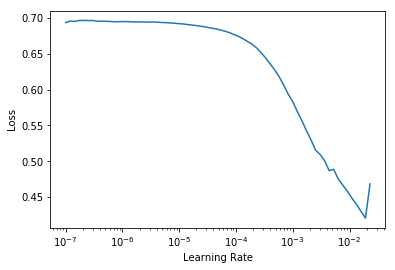

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.634615,0.468488,0.971388,00:01
1,0.454020,0.086979,0.981402,00:01
2,0.314650,0.049240,0.982833,00:01
3,0.237865,0.040424,0.987124,00:01
4,0.188516,0.037785,0.988555,00:01
5,0.155668,0.039817,0.988555,00:01
6,0.132558,0.064628,0.978541,00:01
7,0.117431,0.033528,0.985694,00:01
8,0.105145,0.030035,0.989986,00:01
9,0.093194,0.029549,0.992847,00:01


In [13]:
learn.save("1channel")

## Let's Predict!

In [14]:
learn.load("1channel")

In [15]:
test_dl = learn.dls.test_dl(get_image_files(path/"test"))

In [16]:
test_dl.items

[Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1503.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1605.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1883.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/2032.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/205.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/2642.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3515.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3848.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3878.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/4605.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/4654.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/500.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/5071.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/585.png'),
 Path('F:/WinPy3710/set

In [17]:
outs = learn.get_preds(dl=test_dl)
preds = outs[0].numpy()
predicted_labels=np.argmax(preds,axis=-1)
predicted_labels

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

In [18]:
decoded_pred_labels = L([learn.dls.categorize.decode(x) for x in predicted_labels])
decoded_pred_labels

(#20) ['3','3','7','3','3','7','3','7','7','3'...]

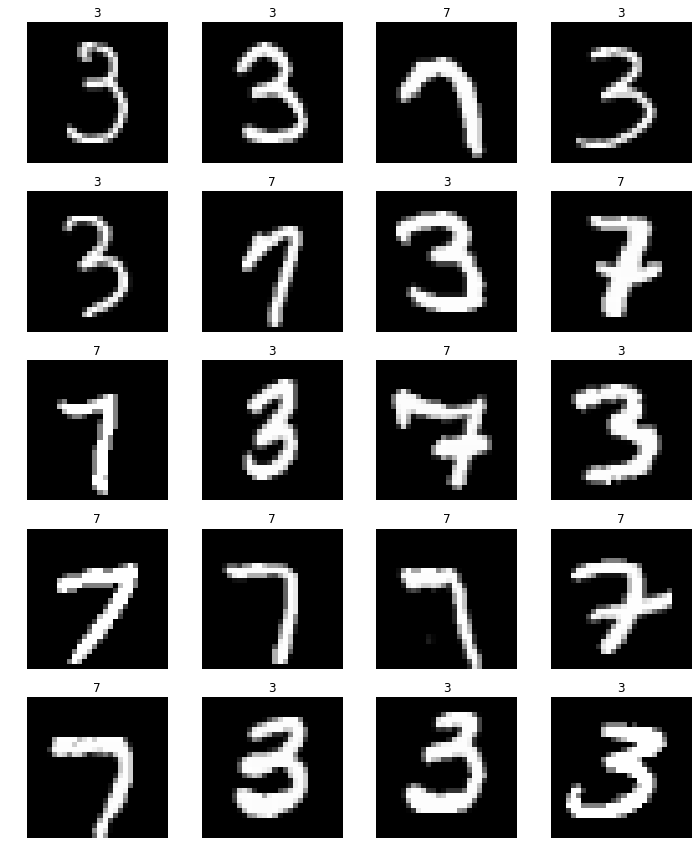

In [19]:
show_images([PILImage.create(img) for img in test_dl.items],titles=decoded_pred_labels,nrows=5,ncols=4)

# 3-channel images

This approach treates the 1-channel images as if they're 3-channel images, all you have to do is use `PILImage` instead of `PILImageBW`

In [20]:
blocks = (ImageBlock(cls=PILImage), CategoryBlock)

In [21]:
dblock = DataBlock(blocks=blocks,
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(),
                   get_y=parent_label)

In [22]:
dls = dblock.dataloaders(path,num_workers=0)

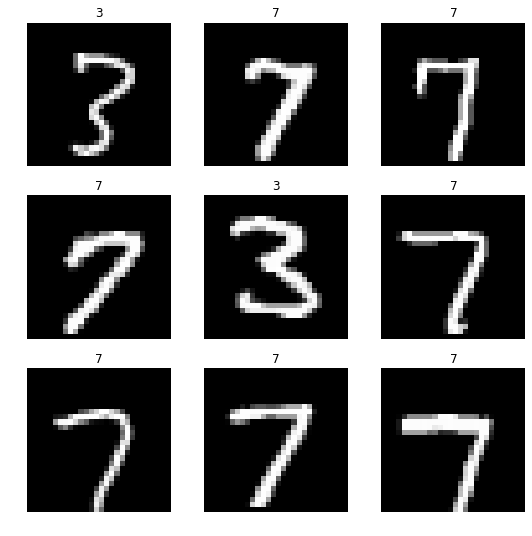

In [23]:
dls.show_batch()

In [24]:
#Let's check the shape of the input images
batch = dls.one_batch()
batch[0].shape #[bs, num_channels, height, width]

torch.Size([64, 3, 28, 28])

Now that we have 3-channel images, we can use `cnn_learner` and do transfer learning!

In [25]:
learn = cnn_learner(dls, models.resnet18, metrics=accuracy)

In [26]:
learn.freeze()

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0020892962347716093)

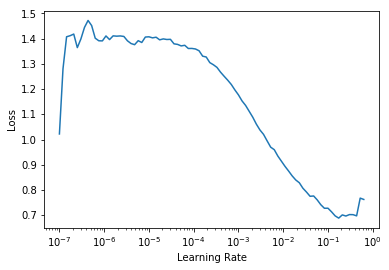

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.718449,0.254873,0.919886,00:02
1,0.462818,0.308275,0.924177,00:01
2,0.306818,0.153716,0.961373,00:01
3,0.216082,0.074384,0.979971,00:01
4,0.159288,0.062812,0.984263,00:01


In [29]:
learn.save("3channel_stage1")

In [30]:
learn.unfreeze()

In [31]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.079759,0.062648,0.987124,00:02
1,0.104251,0.425387,0.938484,00:01
2,0.099296,0.009148,0.995708,00:02
3,0.087666,0.006177,0.995708,00:02
4,0.073061,0.073577,0.975680,00:01
5,0.062956,0.000440,1.000000,00:01
6,0.049776,0.001411,1.000000,00:01
7,0.038154,0.001542,1.000000,00:01
8,0.030104,0.000967,1.000000,00:02
9,0.023885,0.000839,1.000000,00:01


In [32]:
learn.save("3channel_stage2")

## Let's Predict!

In [33]:
learn.load("3channel_stage2")

In [34]:
test_dl = learn.dls.test_dl(get_image_files(path/"test"))

In [35]:
test_dl.items

[Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1503.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1605.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/1883.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/2032.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/205.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/2642.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3515.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3848.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/3878.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/4605.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/4654.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/500.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/5071.png'),
 Path('F:/WinPy3710/settings/.fastai/data/mnist_tiny/test/585.png'),
 Path('F:/WinPy3710/set

In [36]:
outs = learn.get_preds(dl=test_dl)
preds = outs[0].numpy()
predicted_labels=np.argmax(preds,axis=-1)
predicted_labels

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

In [37]:
decoded_pred_labels = L([learn.dls.categorize.decode(x) for x in predicted_labels])
decoded_pred_labels

(#20) ['3','3','7','3','3','7','3','7','7','3'...]

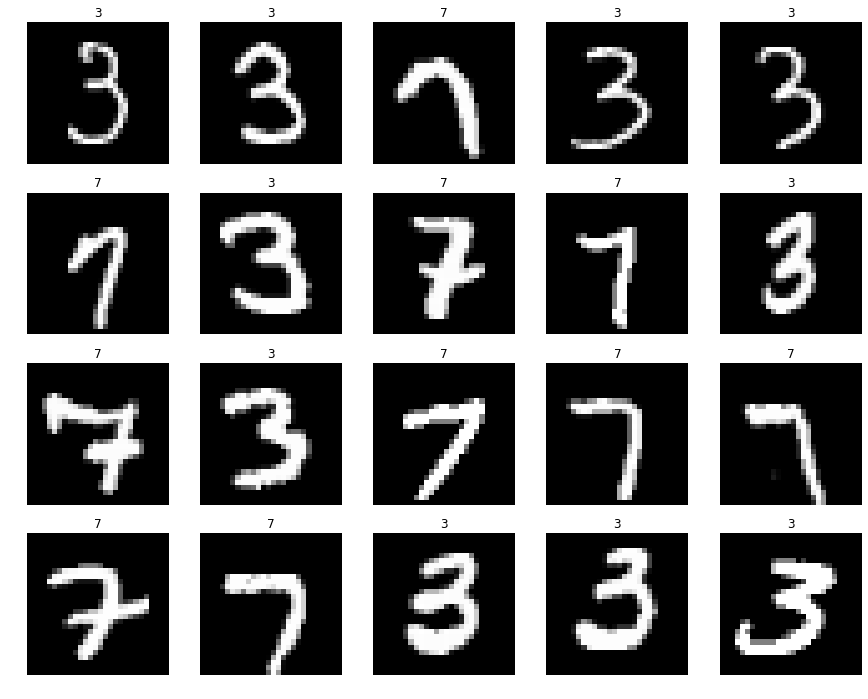

In [38]:
show_images([PILImage.create(img) for img in test_dl.items],titles=decoded_pred_labels,nrows=4,ncols=5)